In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2010",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2010",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2010",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

Using downloaded and verified file: /home/khoidh/data/VOCtrainval_03-May-2010.tar
Extracting /home/khoidh/data/VOCtrainval_03-May-2010.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_03-May-2010.tar
Extracting /home/khoidh/data/VOCtrainval_03-May-2010.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_03-May-2010.tar
Extracting /home/khoidh/data/VOCtrainval_03-May-2010.tar to /home/khoidh/data
#Training Samples: 964
#Validation Samples: 1928
#Testing Samples: 964
#Training Batch: 31
#Validation Batch: 61
#Testing Batch: 31


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0, 15, 21])


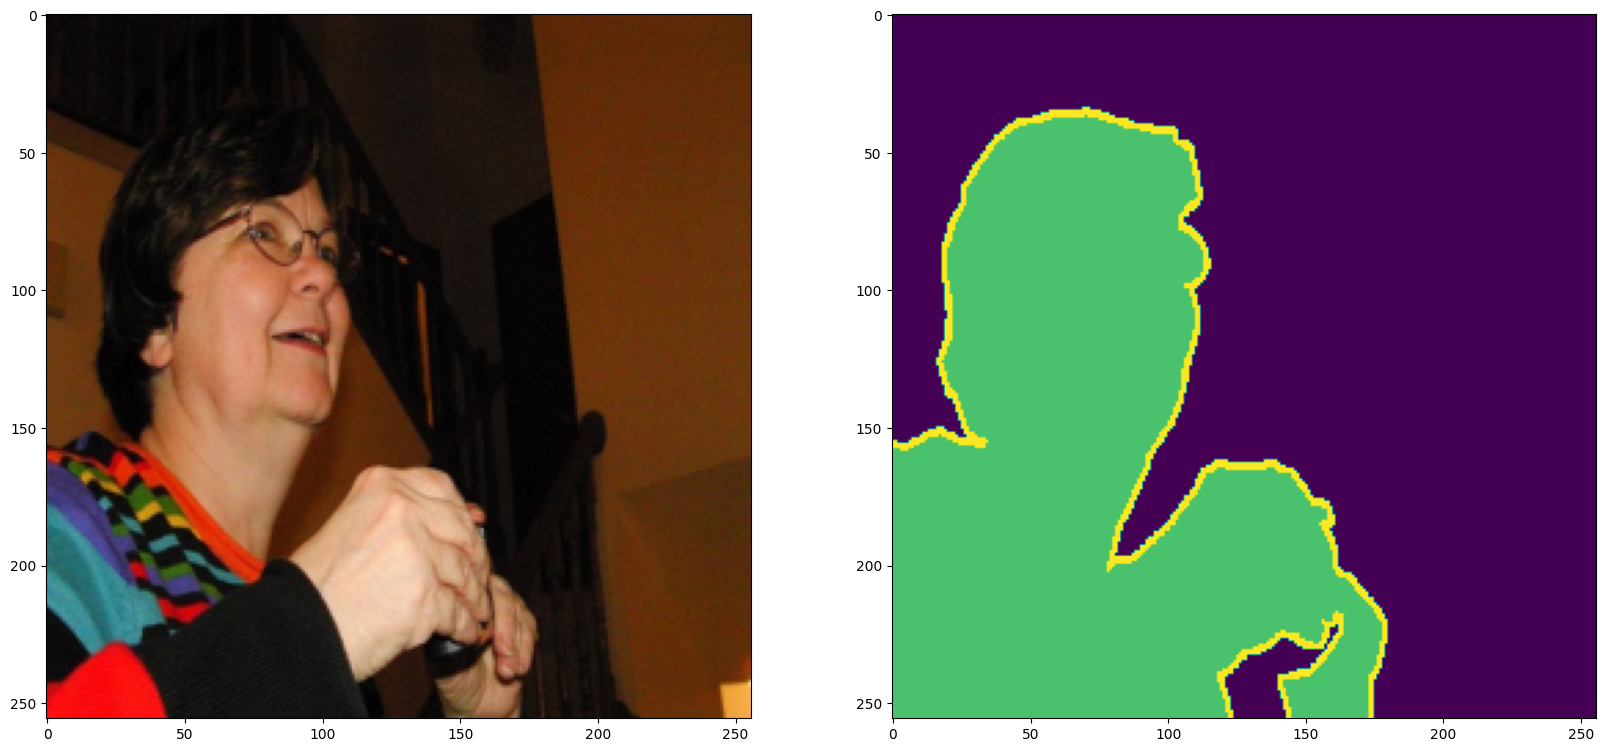

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(valid_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.44it/s]


Epoch: 0 - TrainLoss: 3.582934841032951 - ValidLoss: 4.882336874477199


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.26it/s]


Epoch: 1 - TrainLoss: 2.9664666729588665 - ValidLoss: 2.83852825399305


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.13it/s]


Epoch: 2 - TrainLoss: 2.4398710573873212 - ValidLoss: 2.3971164578297097


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.17it/s]


Epoch: 3 - TrainLoss: 2.054415856638262 - ValidLoss: 2.208180964970198


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.27it/s]


Epoch: 4 - TrainLoss: 1.8320002863484044 - ValidLoss: 1.762199945137149


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.43it/s]


Epoch: 5 - TrainLoss: 1.7187453623740905 - ValidLoss: 1.9394009015599236


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.69it/s]


Epoch: 6 - TrainLoss: 1.6827676603871007 - ValidLoss: 1.6937112886397565


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.51it/s]


Epoch: 7 - TrainLoss: 1.6366948350783317 - ValidLoss: 1.641938045376637


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:09<00:00,  6.29it/s]


Epoch: 8 - TrainLoss: 1.6033532734840148 - ValidLoss: 1.6426205713240827


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  6.04it/s]


Epoch: 9 - TrainLoss: 1.5682612196091683 - ValidLoss: 1.627525894368281


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.50it/s]


Epoch: 10 - TrainLoss: 1.5739949095633723 - ValidLoss: 1.6667132123571928


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.44it/s]


Epoch: 11 - TrainLoss: 1.5360666167351507 - ValidLoss: 1.6083234411771181


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  4.86it/s]


Epoch: 12 - TrainLoss: 1.5202956084282166 - ValidLoss: 1.5909733987245402


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.31it/s]


Epoch: 13 - TrainLoss: 1.5160698083139235 - ValidLoss: 1.5656574651843211


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.37it/s]


Epoch: 14 - TrainLoss: 1.487191657866201 - ValidLoss: 1.5160246579373469


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.35it/s]


Epoch: 15 - TrainLoss: 1.481822971374758 - ValidLoss: 1.5422838105530035


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.38it/s]


Epoch: 16 - TrainLoss: 1.4709523377879974 - ValidLoss: 1.5104035295423914


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.38it/s]


Epoch: 17 - TrainLoss: 1.4414175864188903 - ValidLoss: 1.5134890353093382


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.30it/s]


Epoch: 18 - TrainLoss: 1.4420737143485778 - ValidLoss: 1.5061426065007195


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.35it/s]


Epoch: 19 - TrainLoss: 1.4130669063137424 - ValidLoss: 1.5236353991461582


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.35it/s]


Epoch: 20 - TrainLoss: 1.4235639533688944 - ValidLoss: 1.4962818427164046


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.34it/s]


Epoch: 21 - TrainLoss: 1.3933012793141026 - ValidLoss: 1.4512455228899346


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.34it/s]


Epoch: 22 - TrainLoss: 1.3782637119293213 - ValidLoss: 1.4466904196582857


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.44it/s]


Epoch: 23 - TrainLoss: 1.401548231801679 - ValidLoss: 1.583920895076189


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  4.87it/s]


Epoch: 24 - TrainLoss: 1.3876279900150914 - ValidLoss: 1.4617222508446115


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.64it/s]


Epoch: 25 - TrainLoss: 1.3756590235617854 - ValidLoss: 1.5492409115932027


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.74it/s]


Epoch: 26 - TrainLoss: 1.3516606707726755 - ValidLoss: 1.6257534652459817


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.93it/s]


Epoch: 27 - TrainLoss: 1.3490206426189792 - ValidLoss: 1.404886667845679


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.82it/s]


Epoch: 28 - TrainLoss: 1.33504339379649 - ValidLoss: 1.395433150353979


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.43it/s]


Epoch: 29 - TrainLoss: 1.2889282280398953 - ValidLoss: 1.378256061038033


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.54it/s]


Epoch: 30 - TrainLoss: 1.2937213220903951 - ValidLoss: 1.4366810497690419


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.56it/s]


Epoch: 31 - TrainLoss: 1.281223008709569 - ValidLoss: 1.3884773928611005


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.43it/s]


Epoch: 32 - TrainLoss: 1.2671581583638345 - ValidLoss: 1.3870444043737944


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.54it/s]


Epoch: 33 - TrainLoss: 1.249008959339511 - ValidLoss: 1.4059262764258462


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.65it/s]


Epoch: 34 - TrainLoss: 1.2245642523611746 - ValidLoss: 1.329145664074382


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.78it/s]


Epoch: 35 - TrainLoss: 1.2295269523897479 - ValidLoss: 1.3269351114992236


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.53it/s]


Epoch: 36 - TrainLoss: 1.2222267658479753 - ValidLoss: 1.3619538799661104


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.50it/s]


Epoch: 37 - TrainLoss: 1.1977208679722202 - ValidLoss: 1.4514048509910458


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.61it/s]


Epoch: 38 - TrainLoss: 1.1811583369008956 - ValidLoss: 1.2938646742554962


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.72it/s]


Epoch: 39 - TrainLoss: 1.153766066797318 - ValidLoss: 1.4030480072146556


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.58it/s]


Epoch: 40 - TrainLoss: 1.1648777511812025 - ValidLoss: 1.3288885237740689


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.54it/s]


Epoch: 41 - TrainLoss: 1.172812742571677 - ValidLoss: 1.2977066948765614


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.45it/s]


Epoch: 42 - TrainLoss: 1.1222798881992218 - ValidLoss: 1.2572645388665746


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.96it/s]


Epoch: 43 - TrainLoss: 1.1169287062460376 - ValidLoss: 1.27959469693606


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.56it/s]


Epoch: 44 - TrainLoss: 1.110388994216919 - ValidLoss: 1.3001227759924092


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.61it/s]


Epoch: 45 - TrainLoss: 1.077797741659226 - ValidLoss: 1.2396761423251668


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.52it/s]


Epoch: 46 - TrainLoss: 1.0734187037714067 - ValidLoss: 1.2922484855182836


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.71it/s]


Epoch: 47 - TrainLoss: 1.0875350948302978 - ValidLoss: 1.2488179548842009


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.34it/s]


Epoch: 48 - TrainLoss: 1.043884648430732 - ValidLoss: 1.2333380091385764


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.72it/s]


Epoch: 49 - TrainLoss: 0.9928344065143216 - ValidLoss: 1.223548062512132


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.64it/s]


Epoch: 50 - TrainLoss: 0.9853506799667112 - ValidLoss: 1.1877371365906761


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.46it/s]


Epoch: 51 - TrainLoss: 0.9642278494373444 - ValidLoss: 1.1904104869873797


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.57it/s]


Epoch: 52 - TrainLoss: 1.0040029921839315 - ValidLoss: 1.2593202532314864


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.61it/s]


Epoch: 53 - TrainLoss: 0.9330182325455451 - ValidLoss: 1.198162464821925


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.83it/s]


Epoch: 54 - TrainLoss: 0.9122685501652379 - ValidLoss: 1.3059929697239985


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.52it/s]


Epoch: 55 - TrainLoss: 0.9103285170370533 - ValidLoss: 1.1544992591513963


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.67it/s]


Epoch: 56 - TrainLoss: 0.8716362714767456 - ValidLoss: 1.1709809342368704


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.81it/s]


Epoch: 57 - TrainLoss: 0.870938245327242 - ValidLoss: 1.1296398141345039


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.73it/s]


Epoch: 58 - TrainLoss: 0.8395124308524593 - ValidLoss: 1.1551112454445636


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.64it/s]


Epoch: 59 - TrainLoss: 0.8439325421087204 - ValidLoss: 1.2048656832976419


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.47it/s]


Epoch: 60 - TrainLoss: 0.8408548678121259 - ValidLoss: 1.120472174198901


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch: 61 - TrainLoss: 0.7988707538573973 - ValidLoss: 1.1820437478237464


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.34it/s]


Epoch: 62 - TrainLoss: 0.7907245101467255 - ValidLoss: 1.1167088561370724


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.64it/s]


Epoch: 63 - TrainLoss: 0.7981307006651356 - ValidLoss: 1.1420977789847577


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.44it/s]


Epoch: 64 - TrainLoss: 0.7994885906096427 - ValidLoss: 1.1264214974934939


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  6.00it/s]


Epoch: 65 - TrainLoss: 0.7516700510055788 - ValidLoss: 1.0927530155807246


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.45it/s]


Epoch: 66 - TrainLoss: 0.7434602591299242 - ValidLoss: 1.0865757367650017


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.73it/s]


Epoch: 67 - TrainLoss: 0.7509289633843207 - ValidLoss: 1.0826210985418225


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.37it/s]


Epoch: 68 - TrainLoss: 0.7246190136478793 - ValidLoss: 1.1162417355130931


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.83it/s]


Epoch: 69 - TrainLoss: 0.6918061337163371 - ValidLoss: 1.0926558209247277


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.37it/s]


Epoch: 70 - TrainLoss: 0.6783949482825494 - ValidLoss: 1.0667530610913136


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.80it/s]


Epoch: 71 - TrainLoss: 0.6804772865387702 - ValidLoss: 1.0893275923416263


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.27it/s]


Epoch: 72 - TrainLoss: 0.6766242875206855 - ValidLoss: 1.0744470142927327


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.26it/s]


Epoch: 73 - TrainLoss: 0.6305705145482094 - ValidLoss: 1.0469730193497704


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:10<00:00,  5.58it/s]


Epoch: 74 - TrainLoss: 0.6322492726387516 - ValidLoss: 1.0579734600958277


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.36it/s]


Epoch: 75 - TrainLoss: 0.6162455370349269 - ValidLoss: 1.0356953886688733


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.15it/s]


Epoch: 76 - TrainLoss: 0.6040972144373001 - ValidLoss: 1.0540802732842867


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.15it/s]


Epoch: 77 - TrainLoss: 0.6126266506410414 - ValidLoss: 1.0474501809135812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.09it/s]


Epoch: 78 - TrainLoss: 0.5969716685433542 - ValidLoss: 1.0313545397070587


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.24it/s]


Epoch: 79 - TrainLoss: 0.5688445712289503 - ValidLoss: 1.0253830219878526


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  4.75it/s]


Epoch: 80 - TrainLoss: 0.581335703211446 - ValidLoss: 1.0199804853220455


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  5.05it/s]


Epoch: 81 - TrainLoss: 0.5642492396216239 - ValidLoss: 1.0279003880063042


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  5.02it/s]


Epoch: 82 - TrainLoss: 0.5541641548756631 - ValidLoss: 1.0379903140615245


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.28it/s]


Epoch: 83 - TrainLoss: 0.5470186875712487 - ValidLoss: 1.0192110001063737


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.33it/s]


Epoch: 84 - TrainLoss: 0.5510921487885136 - ValidLoss: 1.0243422496514243


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.13it/s]


Epoch: 85 - TrainLoss: 0.5418159461790516 - ValidLoss: 1.019435528848992


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.24it/s]


Epoch: 86 - TrainLoss: 0.527990589218755 - ValidLoss: 1.0218837065774886


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.48it/s]


Epoch: 87 - TrainLoss: 0.5359121272640843 - ValidLoss: 1.0219724969785722


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.22it/s]


Epoch: 88 - TrainLoss: 0.5322717476275659 - ValidLoss: 1.0133187047770766


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  4.93it/s]


Epoch: 89 - TrainLoss: 0.5277235219555516 - ValidLoss: 1.0155623232732054


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.14it/s]


Epoch: 90 - TrainLoss: 0.5567737923514459 - ValidLoss: 1.025161840876595


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  6.91it/s]


Epoch: 91 - TrainLoss: 0.5360991925962509 - ValidLoss: 1.0257276961060822


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.42it/s]


Epoch: 92 - TrainLoss: 0.5098659944149756 - ValidLoss: 1.0208458323947718


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.48it/s]


Epoch: 93 - TrainLoss: 0.5267114389327264 - ValidLoss: 1.0213166651178578


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.45it/s]


Epoch: 94 - TrainLoss: 0.4965739807774944 - ValidLoss: 1.0186445224480551


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.61it/s]


Epoch: 95 - TrainLoss: 0.5193568006638558 - ValidLoss: 1.0170572566204383


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.36it/s]


Epoch: 96 - TrainLoss: 0.5298877714141723 - ValidLoss: 1.0191127403837736


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.52it/s]


Epoch: 97 - TrainLoss: 0.5307540951236602 - ValidLoss: 1.0203318771768788


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.40it/s]


Epoch: 98 - TrainLoss: 0.5127799011045887 - ValidLoss: 1.009132216211225


100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:08<00:00,  7.37it/s]

Epoch: 99 - TrainLoss: 0.5414805268087695 - ValidLoss: 1.0186693658594226


<All keys matched successfully>

In [12]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

100%|███████████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.36it/s]

TestLoss: 1.6036001366953696


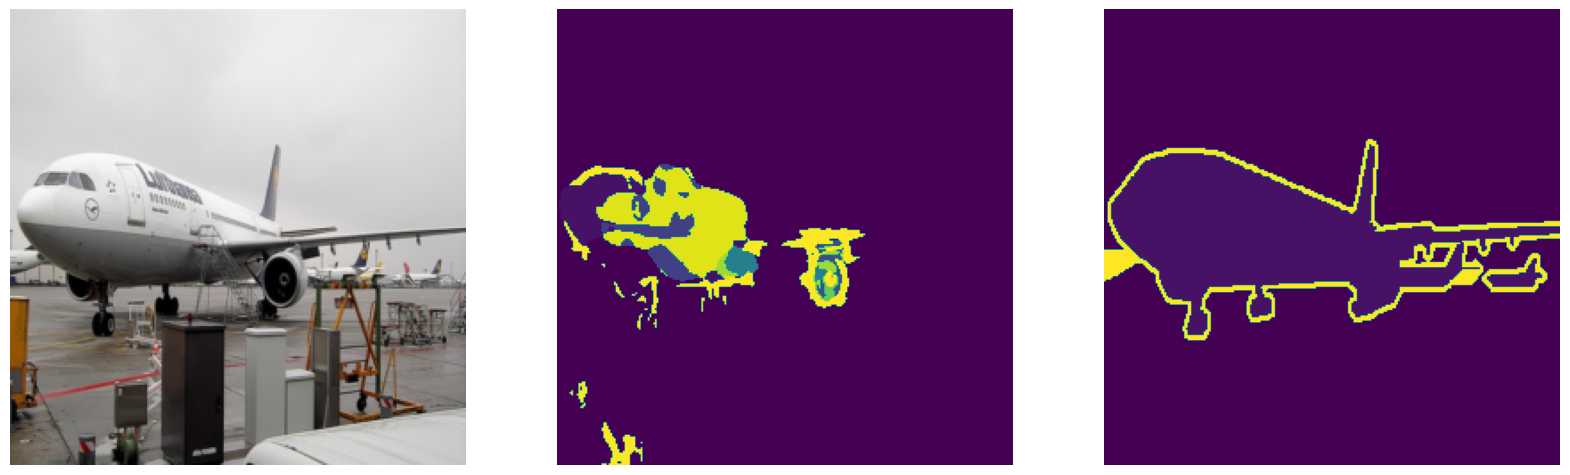

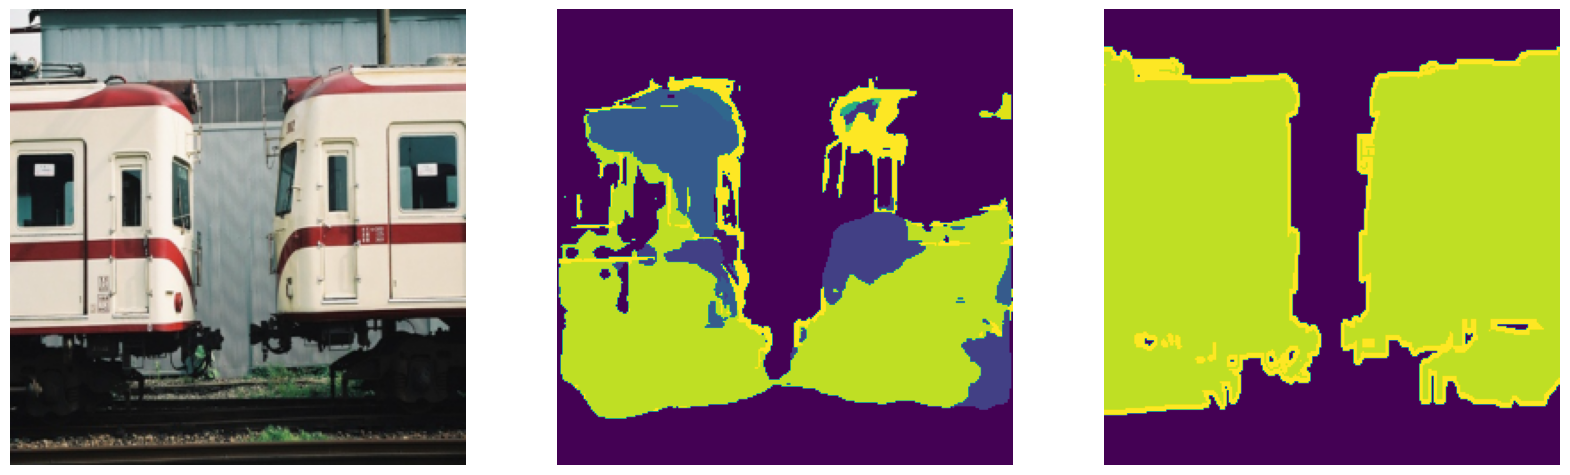

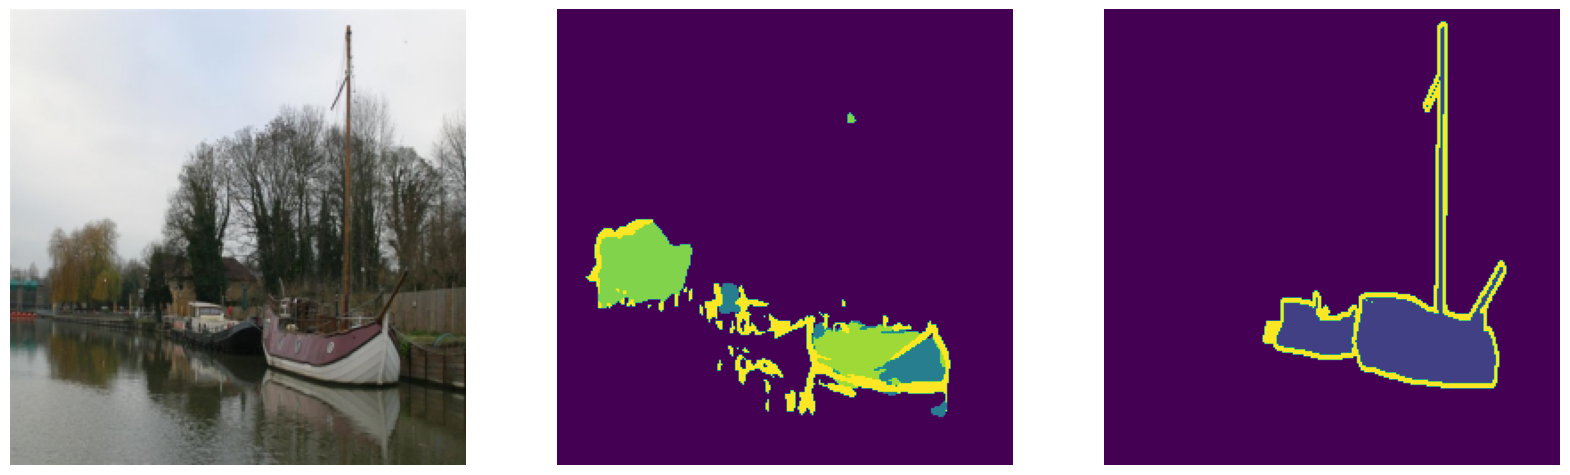

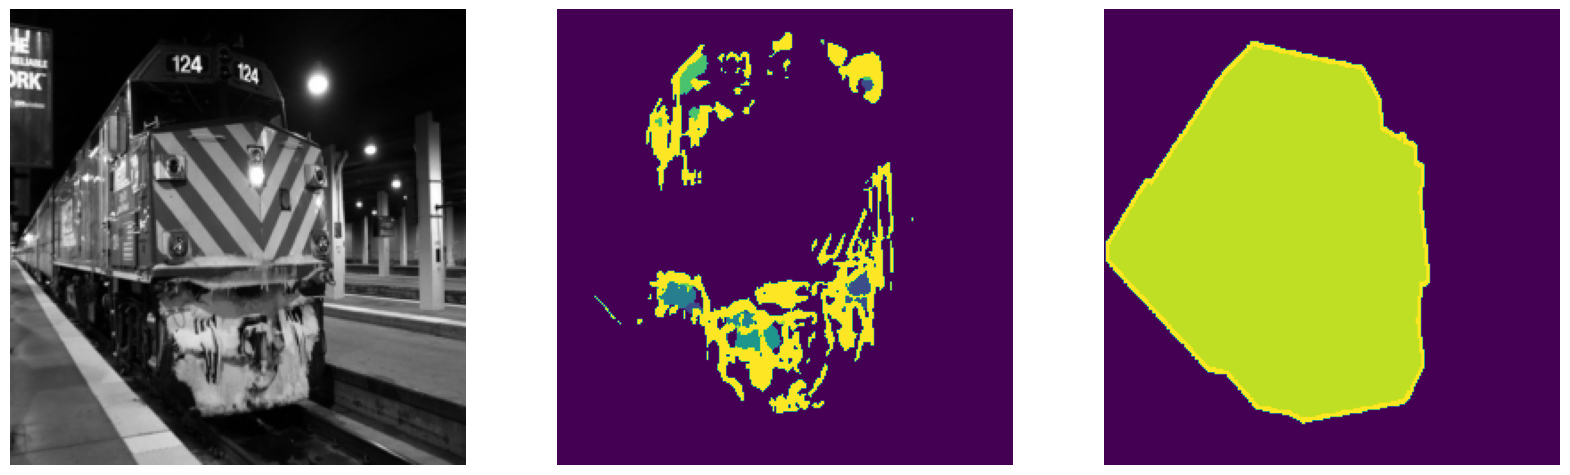

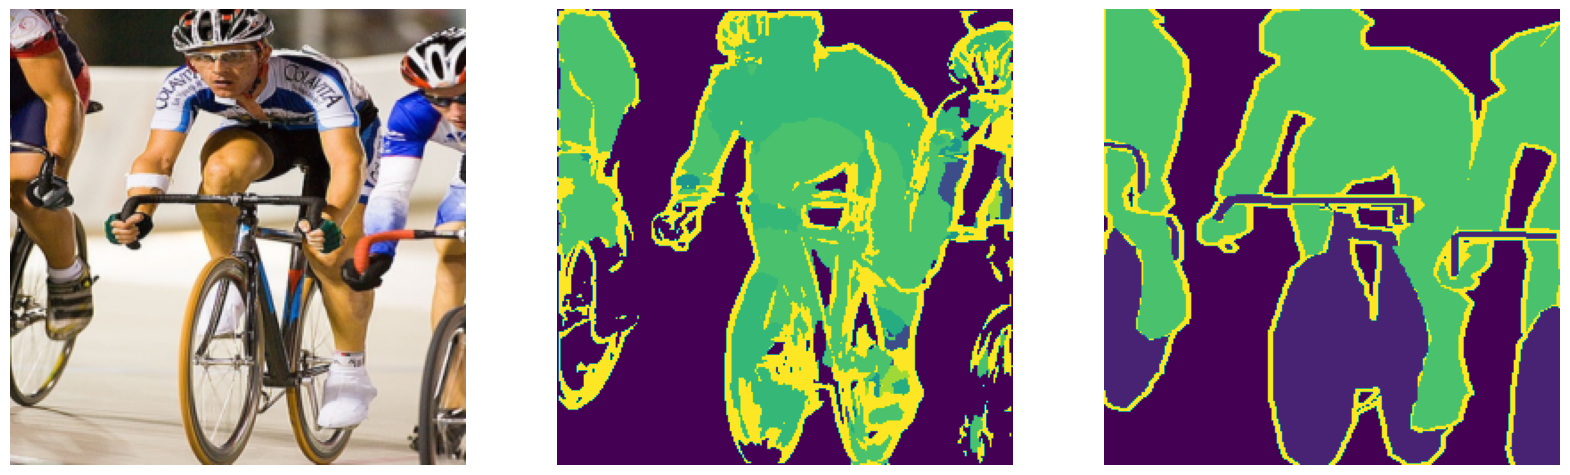

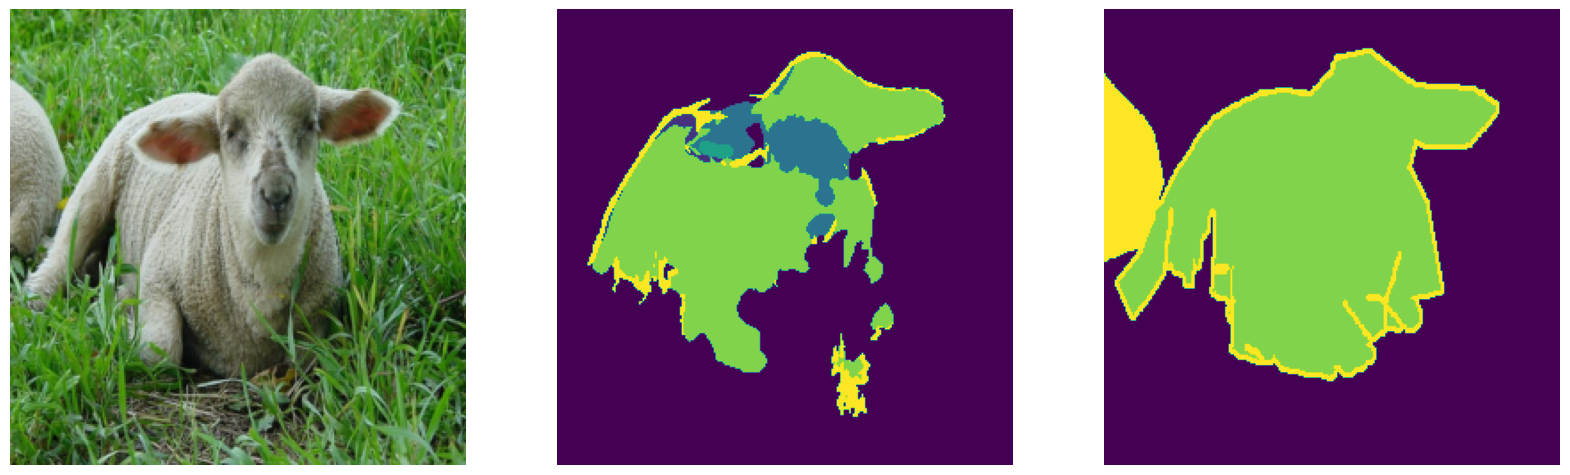

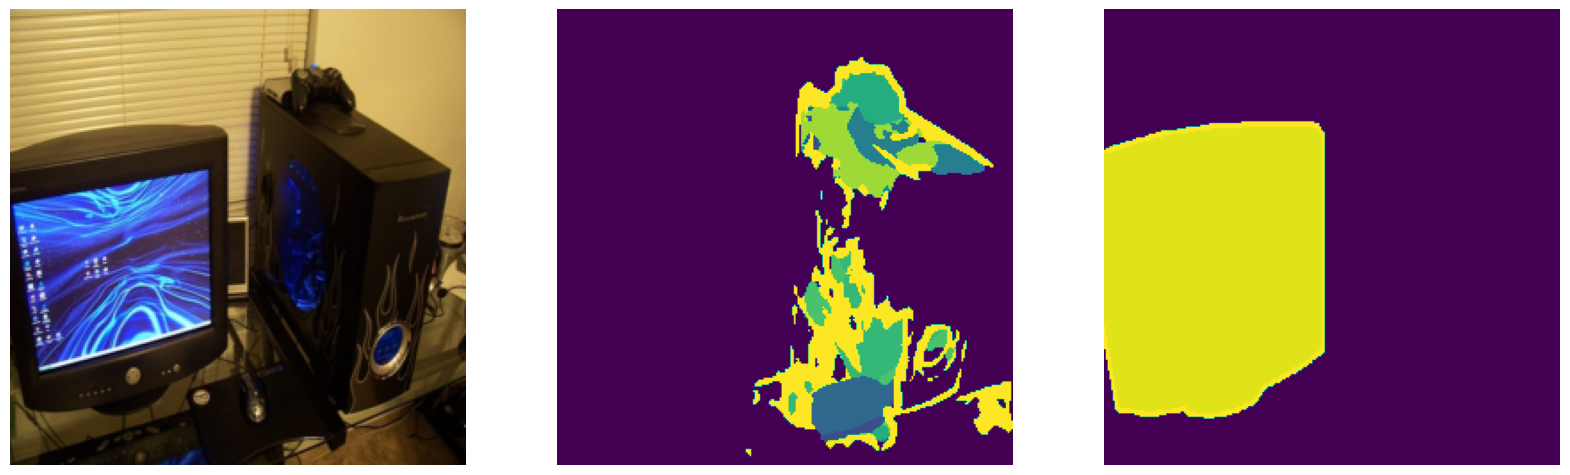

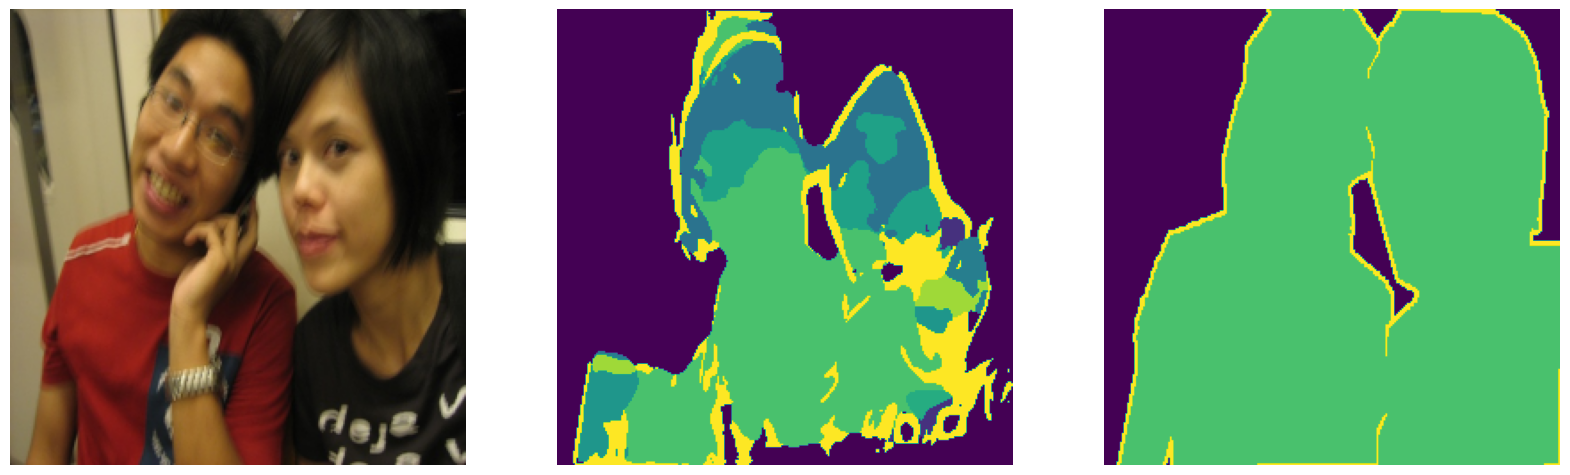

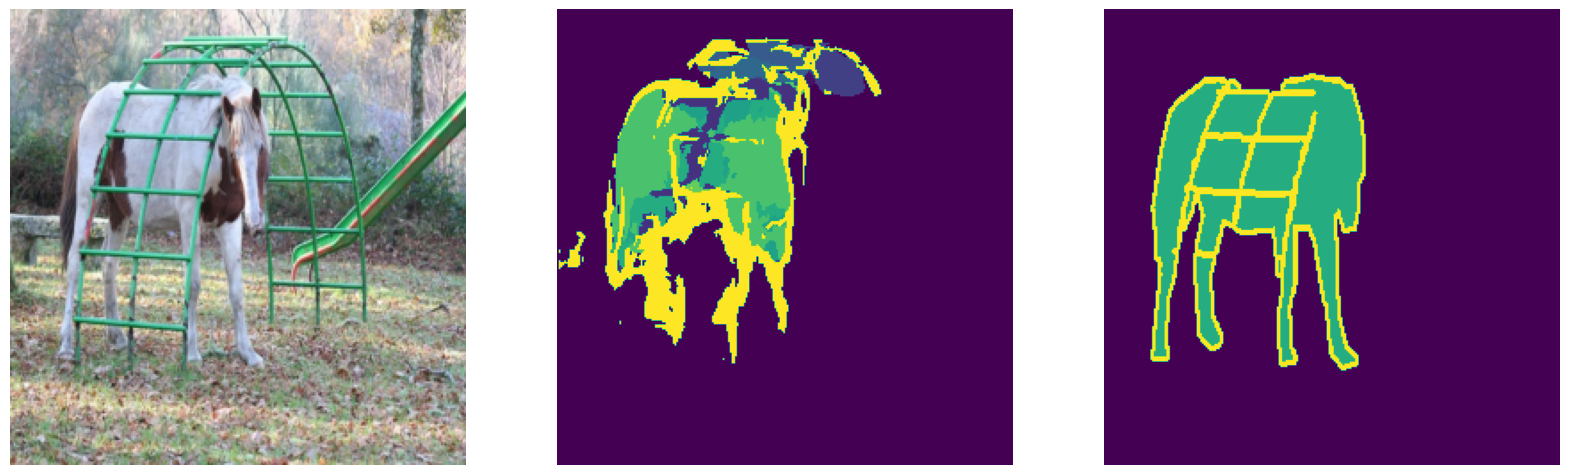

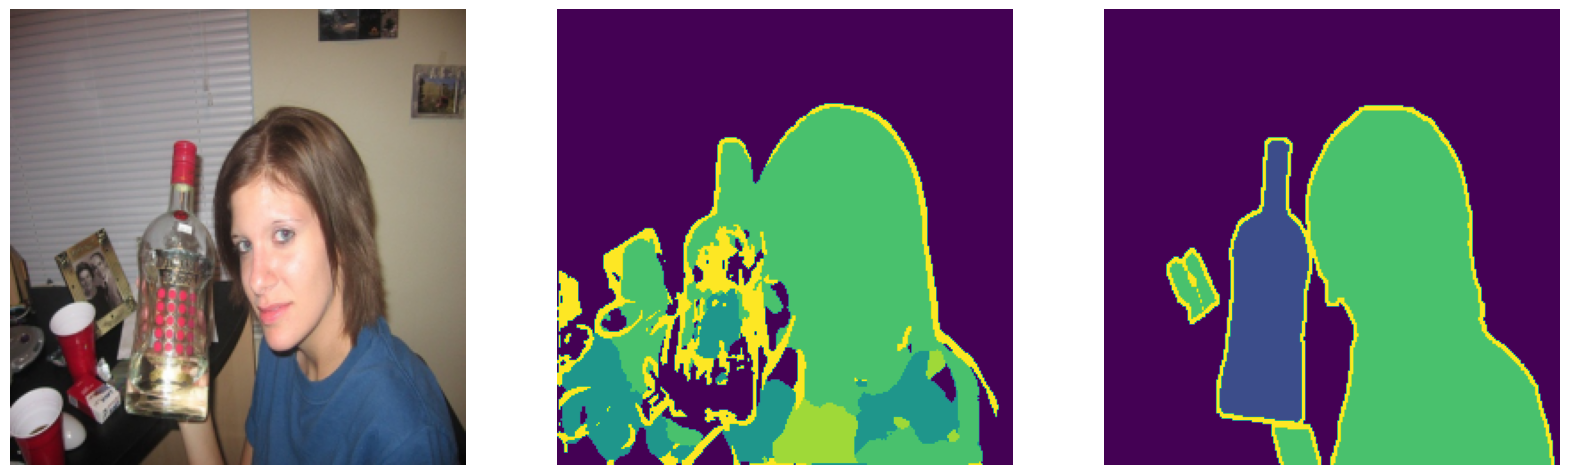

In [13]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')